# i1_graph 
File that contain all analysis done on Graph constructed with interactions

In [1]:
import networkx as nx
import import_ipynb
import h2_ENb_gen as h2
import h1_ENB_occ as h1
import g1_generate_dictionary as g1
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import pandas as pd
import pycountry
import numpy as np
import random 
import networkx.algorithms.community
import community
from community import community_louvain
import matplotlib.patches as mpatches

importing Jupyter notebook from h2_ENb_gen.ipynb
importing Jupyter notebook from c1_extract_paragraphe_issue.ipynb
importing Jupyter notebook from c2_extract_sentence_issue.ipynb
importing Jupyter notebook from g1_generate_dictionary.ipynb
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
importing Jupyter notebook from h1_ENB_occ.ipynb


In [2]:
# Dictionary for each COP (key) with the issues related to it (values)
dict_cop = {1: np.arange(12,22),
            2: np.arange(29,38),
            3: np.arange(68,76),
             4: np.arange(88,97),
             5 : np.arange(113,123),
             6: np.arange(153,163),
             7: np.arange(179,189),
             8: np.arange(200,209),
             9: np.arange(222,230),
             10: np.arange(250,260),
             11: np.arange(281,291),
             12: np.arange(308,318),
             13: np.arange(344,354),
             14: np.arange(386,395),
             15: np.arange(449,459),
             16: np.arange(488,497),
             17: np.arange(524,534),
             18: np.arange(557,567),
             19: np.arange(584,593),
             20 : np.arange(609,619),
             21: np.arange(653,663),
             22: np.arange(679,689),
             23: np.arange(704,714),
             24: np.arange(736,747),
             25: np.arange(765,774)}

In [16]:
def create_dict():
    """Create dictionary that can map entities with an id but also map entities from the original to the generated dataset. """
    DICTIONARY = g1.compute_dictionary()
    n = 0
    DICTIONARY_NUM = dict()
    for k in DICTIONARY:

        DICTIONARY_NUM[n] = k
        n +=1
    NAMES = []
    for x in DICTIONARY.values():
        if(len(x) == 1):
            NAMES.append(x[0])

        else:
            NAMES += [k for k in x]
    return DICTIONARY, DICTIONARY_NUM, NAMES

In [17]:
DICTIONARY, DICTIONARY_NUM, NAMES = create_dict()

In [4]:
def  extract_df_cop1(cooperation,issue_cop):
    """Create the dataframe with all the interactiom ,if the cooperation = True, return all the cooperation otherwise all the oppositions. """
    frames = []
    for i in issue_cop:
        df = h1.extract_relationships_count(i)[0]
        frames.append(df)
    df_combine = pd.concat(frames)
    df_combine['Country A'] = df_combine['Country A'].apply(lambda x: x.upper())
    df_combine['Country B'] = df_combine['Country B'].apply(lambda x: x.upper())
    df_combine= df_combine.drop(['type','issue','behalf','support','agreement','opposition','criticism','sentences'],axis = 1)
    if(cooperation):
        df_combine = df_combine.loc[df_combine['cooperation'] == 1]
    else : 
        df_combine = df_combine.loc[df_combine['cooperation'] == 0]

    grouped = df_combine.groupby(['id_ca','id_cb','Country A','Country B'],as_index=False).count()

    
    return grouped

In [5]:
def extract_df_cop(issue_cop, cooperation):
    """Create the dataframe with all the interactiom ,if the cooperation = True, return all the cooperation otherwise all the oppositions. """
    frames = []
    for i in issue_cop:
        df = h2.interactions(i)[0]
        frames.append(df)
    df_combine = pd.concat(frames)
    df_combine['Country A'] = df_combine['Country A'].apply(lambda x: x.upper())
    df_combine['Country B'] = df_combine['Country B'].apply(lambda x: x.upper())
    df_combine= df_combine.drop(['type','issue'],axis = 1)
    df_support = df_combine.loc[df_combine['agreement'] == 1].drop_duplicates(keep = False)
    num_support = len(df_support.to_numpy())
    print(len(df_combine['Country A'].to_numpy()))
    df_combine= df_combine.drop(['behalf','support','agreement','opposition','criticism','sentences'],axis = 1)
    if(cooperation):
        df_combine = df_combine.loc[df_combine['cooperation'] == 1]
    else : 
        df_combine = df_combine.loc[df_combine['cooperation'] == 0]

    grouped = df_combine.groupby(['id_ca','id_cb','Country A','Country B'],as_index=False).count()

    
    return grouped

In [6]:
def graph_cop(df_cop, direct):
    """Create the directed weighted graph from the dataframe. """
    if(direct):
        G=nx.DiGraph()
        print('bof')
    else :
        G = nx.Graph()
    #Creates nodes
    nodes =  list(set(list(df_cop['id_ca'].to_numpy()) + list(df_cop['id_cb'].to_numpy())))
    G.add_nodes_from(nodes)
    # Create edges
    edges = list(zip(df_cop['id_ca'], df_cop['id_cb']))
    G.add_edges_from(edges)
     # Create weights of the edges
    df_edges = df_cop.drop(['Country A','Country B'], axis = 1)
    list_weigths = list(df_edges.to_records(index = False))
    G.add_weighted_edges_from(list_weigths)
    
    return G, list_weigths

In [134]:
def plot_graph(G, issue_cop):
    """Plot the directed weighted graph from the dataframe. """
    pos = nx.spring_layout(G, k=2.5)
    figsize = (30,15)
    fig, axe = plt.subplots(1, 1, figsize=figsize)
    s = ""
    plt.title(s, fontsize=18)
    names = dict([(n,DICTIONARY_NUM[n]) for n in G.nodes])
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    labels=nx.draw_networkx_labels(G,pos=pos, labels= names,font_size = 20 ,font_color = 'k',font_weight='bold')
    nx.draw_networkx(G, pos = pos, edges=edges, edge_color='grey', node_size=10, node_color ='k',width = weights, arrows = True)

In [56]:
def centrality(dict_cent, x):
    """Find of the node if it is present during negotiation of a specific COP. """
    if(x in dict_cent):
        return dict_cent[x]
    else :
        return 0

In [31]:
def keek_c():
    df_ch = pd.DataFrame()
    df_us = pd.DataFrame()
    df_cr = pd.DataFrame()
    df_tu = pd.DataFrame()
    df_eu = pd.DataFrame()
    for i in range(1,26):
        frames_ch = []
        frames_us = []
        frames_croatia = []
        frames_tuv = []
        frames_eu = []
        for j in dict_cop[i]:
            df = h2.interactions(j)[0]
            df['cop'] = i
            df_ch = pd.concat([df_ch,df.loc[(df['id_ca'] == 102) | (df['id_cb'] == 102)]])
            df_us = pd.concat([df_us,df.loc[(df['id_ca'] == 170) | (df['id_cb'] == 170)]])
            df_cr = pd.concat([df_cr,df.loc[(df['id_ca'] == 61) | (df['id_cb'] == 61)]])
            df_tu = pd.concat([df_tu,df.loc[(df['id_ca'] == 17) | (df['id_cb'] == 17)]])
            df_eu = pd.concat([df_eu,df.loc[(df['id_ca'] == 0) | (df['id_cb'] == 0)]])

    
    return  df_ch, df_us, df_cr, df_tu, df_eu

In [32]:
df_ch, df_us, df_cr, df_tu, df_eu= keek_c()

Issue  12
Issue  13
Issue  14
Issue  15
Issue  16
Issue  17
Issue  18
Issue  19
Issue  20
Issue  21
Issue  29
Issue  30
Issue  31
Issue  32
Issue  33
Issue  34
Issue  35
Issue  36
Issue  37
Issue  68
Issue  69
Issue  70
Issue  71
Issue  72
Issue  73
Issue  74
Issue  75
Issue  88
Issue  89
Issue  90
Issue  91
Issue  92
Issue  93
Issue  94
Issue  95
Issue  96
Issue  113
Issue  114
Issue  115
Issue  116
Issue  117
Issue  118
Issue  119
Issue  120
Issue  121
Issue  122
Issue  153
Issue  154
Issue  155
Issue  156
Issue  157
Issue  158
Issue  159
Issue  160
Issue  161
Issue  162
Issue  179
Issue  180
Issue  181
Issue  182
Issue  183
Issue  184
Issue  185
Issue  186
Issue  187
Issue  188
Issue  200
Issue  201
Issue  202
Issue  203
Issue  204
Issue  205
Issue  206
Issue  207
Issue  208
Issue  222
Issue  223
Issue  224
Issue  225
Issue  226
Issue  227
Issue  228
Issue  229
Issue  250
Issue  251
Issue  252
Issue  253
Issue  254
Issue  255
Issue  256
Issue  257
Issue  258
Issue  259
Issue  281
Is

df_cr

out_d = []
in_d = []
tot = []
for i in range(1,26):
    out_d.append(len(df_cr.loc[(df_ch['cop'] == i) & (df_cr['Country A'] == 'CHINA')].to_numpy()))
    in_d.append(len(df_ch.loc[(df_ch['cop'] == i) & (df_ch['Country B'] == 'CHINA')].to_numpy()))
    #tot.append( len( df_us.loc[df_us['cop'] == i & ( (df_ch['Country B'] == 'US') | (df_ch['Country A'] =='US') )].to_numpy()  ) )

print((out_d))
print((in_d))


# China
out [5, 28, 40, 22, 47, 57, 31, 34, 17, 4, 13, 16, 51, 24, 45, 8, 6, 105, 74, 95, 12, 34, 9, 7, 12]
int [5, 29, 39, 24, 45, 37, 25, 37, 16, 6, 10, 13, 40, 23, 51, 9, 6, 89, 72, 101, 16, 24, 9, 7, 12]

#US 
[19, 54, 51, 85, 92, 152, 13, 59, 56, 71, 13, 16, 44, 6, 17, 12, 10, 34, 53, 100, 36, 52, 11, 8, 29]
[21, 53, 49, 88, 90, 156, 14, 48, 52, 75, 16, 15, 48, 7, 16, 11, 16, 39, 68, 83, 34, 54, 10, 8, 26]

#EU 
[32, 22, 33, 73, 94, 106, 72, 117, 106, 81, 50, 52, 102, 35, 60, 13, 15, 24, 51, 87, 45, 55, 17, 43, 26]
[34, 25, 37, 75, 90, 98, 84, 122, 107, 79, 56, 59, 92, 36, 63, 18, 14, 27, 56, 91, 46, 51, 19, 42, 29]

# Tuvalu
[0, 0, 1, 11, 23, 21, 0, 9, 7, 0, 3, 5, 28, 3, 33, 13, 5, 5, 0, 8, 12, 6, 0, 0, 0]
[0, 0, 1, 10, 23, 23, 0, 9, 5, 0, 7, 3, 19, 3, 35, 12, 5, 5, 0, 8, 14, 7, 0, 0, 0]
#CROATIA
[10, 0, 8, 12, 0, 0, 0, 9, 4, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 2, 0, 0, 0, 0, 0]
[10, 0, 8, 12, 0, 0, 0, 9, 4, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0]

In [ ]:
53, 68

51, 56

In [62]:
np.mean([10, 0, 8, 12, 0, 0, 0, 9, 4, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0])

2.2

In [63]:
china = np.zeros(25)
us = np.zeros(25)
croatia = np.zeros(25)
tuvalu = np.zeros(25)
eu = np.zeros(25)
for i in range(1,26):

    china[i-1] = page_score[i-1][29]
    us[i-1] = page_score[i-1][157]
    if(26 in page_score[i-1]):
        croatia[i-1] = page_score[i-1][26]
    if(184 in page_score[i-1]):
        tuvalu[i-1] = page_score[i-1][184]
    if(193 in page_score[i-1]):
        eu[i-1] = page_score[i-1][193]

In [8]:
def compute_centrality_COP(cop_number,top_n, print_top):
    """Find the centrality of each node present in the Graph of a specific COP. """
    
    #Create dataframe with nodes and centrality for first COP 
    df_nodes = pd.DataFrame()
    df_nodes['id_c'] = list(DICTIONARY_NUM.keys())
    df_nodes['Country'] = df_nodes['id_c'].apply(lambda x : DICTIONARY_NUM[x])
    issues_cop = dict_cop[cop_number]
    df_cop = extract_df_cop(issues_cop, True)
    G_cop, list_weights = graph_cop(df_cop, False)
    cent_deg_dict = nx.degree_centrality(G_cop)
    cent_s = 'centrality COP'+str(cop_number)
    df_nodes[cent_s] = df_nodes['id_c'].apply(lambda x : centrality(cent_deg_dict, x))
    df_nodes = df_nodes.drop(['Country'],axis = 1)
    list_tuples = [tuple(x) for x in df_nodes.to_numpy()]
    idc = [int(x[0]) for x in list_tuples]
    val = [x[1] for x in list_tuples]
    return dict(list(zip(idc,val)))

In [9]:
def pageRank_COP(cop_number, top_n, print_top) :
    """Find the PageRank score of each node present in the Graph of a specific COP. """
    issues_cop = dict_cop[cop_number]
    df_cop = extract_df_cop(issues_cop, True)
    G_cop, list_weights = graph_cop(df_cop, True)
    pr = nx.pagerank(G_cop)
    return pr

In [10]:
def plot_interactions_rank_COP(china, us, croatia, tuvalu, eu):
    """Plot for Switzerland, US, China, Saudi Arabia and Tuvalu their score (PageRak or Centrality) for all COPs. """
    
    #Plot the interventions
    index = np.arange(1,26)
    figsize = (24,9)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    csfont = {'fontname':'Helvetica','fontsize':'18' }
    hfont = {'fontname':'Helvetica','fontsize':'16'}

    #plt.title('PageRank Score for five entities',**csfont)
    plt.xlabel("COPs in chronological order", **hfont)
    plt.ylabel("PageRank Score", **hfont)

    x = index
    red_patch = mpatches.Patch(color='limegreen', label='United States')
    c_patch = mpatches.Patch(color='red', label='China')
    b_patch = mpatches.Patch(color='dodgerblue', label='EU')
    a_patch = mpatches.Patch(color='darkorange', label='Croatia')
    t_patch = mpatches.Patch(color='purple', label='Tuvalu')
    plt.legend(handles=[b_patch,c_patch,red_patch, a_patch, t_patch])
    plt.plot(x, eu, color='dodgerblue', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    plt.plot(x, china, color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    plt.plot(x, us, color='limegreen', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    plt.plot(x, croatia, color='darkorange', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    plt.plot(x, tuvalu, color='purple', marker='o', linestyle='dashed',linewidth=2, markersize=12)
    
    """ax.bar(x-0.3, swiss, width=0.15, color='dodgerblue', align='center')
    ax.bar(x-0.15, china, width=0.15, color='red', align='center')
    ax.bar(x+0.0, us, width=0.15, color='limegreen', align='center')
    ax.bar(x+0.15, g77, width=0.15, color='darkorange', align='center')
    ax.bar(x+0.3, brazil,  width=0.15, color='yellow', align='center') """
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))

    plt.show()

In [81]:
def ego_graph(entity, df_cop):
    """Return the Ego graph during a specific COP of one entity. """
    df_ego = df_cop.loc[df_cop['Country B'].isin([entity])]
    out = df_cop.loc[df_cop['Country A'].isin(['CROATIA']) & df_cop['Country B'].isin(['EU'])]
    in_ = df_cop.loc[df_cop['Country B'].isin(['CROATIA']) & df_cop['Country A'].isin(['EU'])]

    G_cop,l = graph_cop(df_ego, direct = False)
    return G_cop, out, in_

In [136]:
issues_cop = dict_cop[20]
df_cop = extract_df_cop(issues_cop, False)
g = graph_cop(df_cop, True)


Issue  609
Issue  610
Issue  611
Issue  612
Issue  613
Issue  614
Issue  615
Issue  616
Issue  617
Issue  618
1495
bof


In [137]:
np.mean([x[1] for x in list(g[0].in_degree(weight='weight'))])

2.6216216216216215

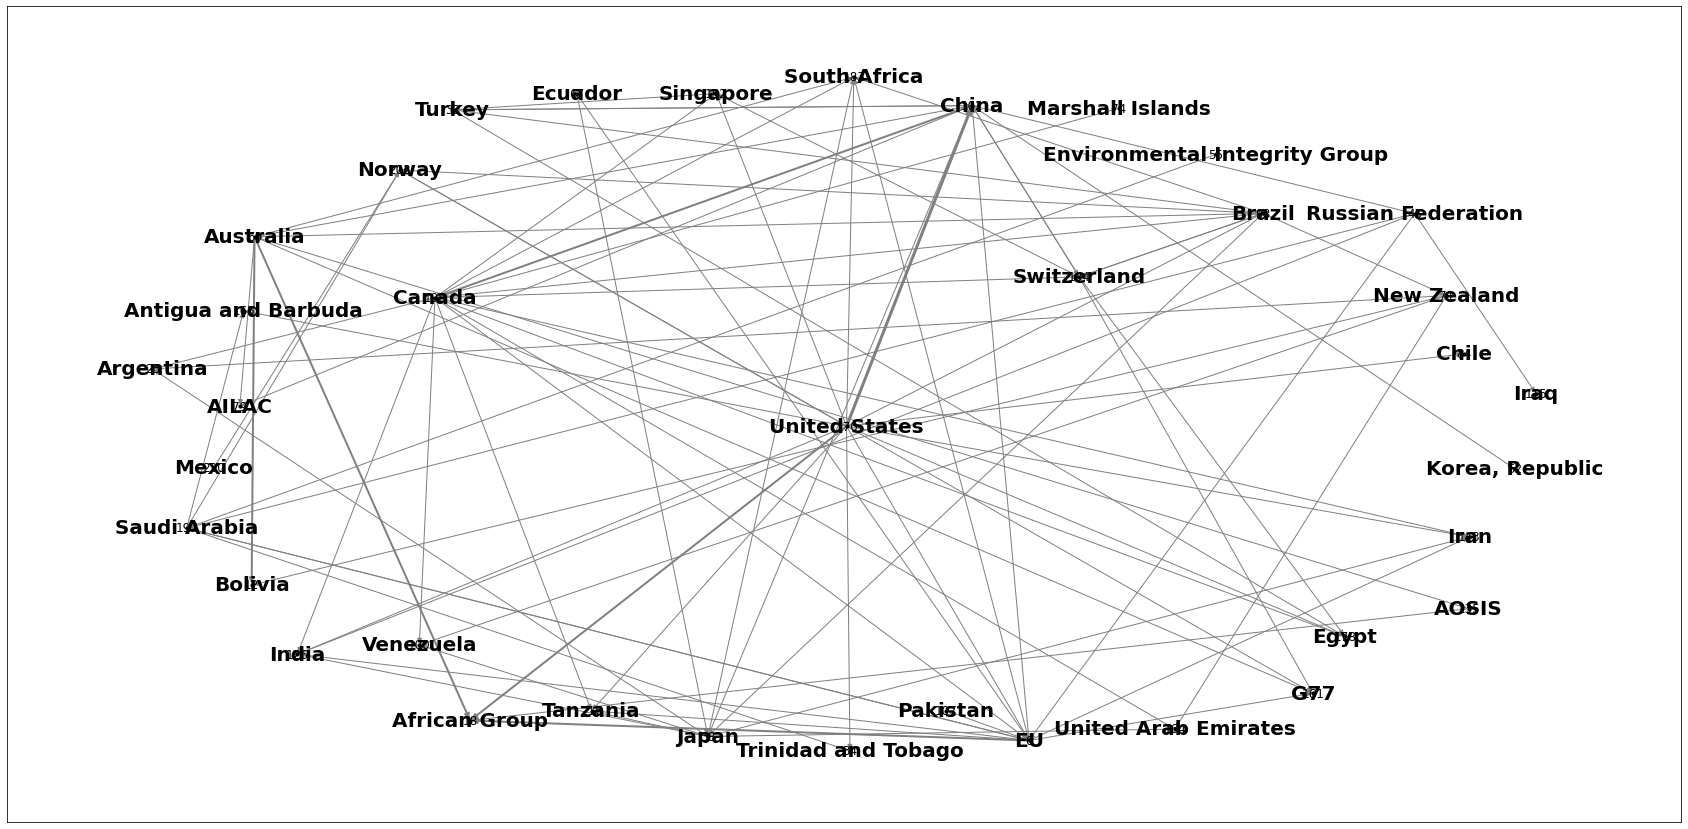

In [138]:
plot_graph(g[0],1)